In [8]:
## import python modules
#for creating the plots
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.ticker as mticker

import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
import datetime

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

#for performing the analysis on the data
import math

import scipy
import signal
import scipy.fft as fft
import scipy.signal as signal
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')



# CODE BEFORE THE NEXT TITLE IS TAKEN FROM MY PREVIOUS RESEARCH

In [ ]:
buoy_path ='/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_' #pathing to the files used for buoyancy
precip_path='/neelin2020/TRMM_3B42/TRMM.3hrly.3B42.' #same for the precipitation

In [ ]:
number = []
offset = []
non_landfall = []
landfall = []
tropics = []

class hurricance:
    
    def __init__(self,year,paths):
        self.year=year
        self.buoy_path=paths[0]
        self.precip_path=paths[1]
        #self.buoy_path=paths[2]
        self.offset=5 ## box size in deg. lat/lon around feature center
        offset.append(self.offset)
    def __extract_dates(self,date_array):
        dates=[]
        for n in range(date_array.shape[0]):
            yr,mo,dy,hr=np.int_(date_array[n])
            dates.append(dt.datetime(yr,mo,dy,hr))
        
        return dates    
    
    def extract_tracks(self):
        
        ### read Tempest Extremes Tracks for ERA-5
        fili='/neelin2020/TempestExtremes/TC/ERA5_TC_tracks_20200824.txt'
        
        f=open(fili,'r')
        lines = f.readlines()    # Read file and close
        f.close()

        i=0
        self.tc_tracks={}
        ctr=0

        while (i < (len(lines)-1) ):
            line = lines[i]
            i = i+1
            linesplit = line.strip().split('\t')
            if linesplit[0] == 'start' :
                tracklength = int(linesplit[1])
                trackarray = np.genfromtxt(lines[i:(i+tracklength)])
                dates=self.__extract_dates(np.int_(trackarray[:,-4:]))
                lon=trackarray[:,2]
                lat=trackarray[:,3]
                psl=trackarray[:,4]*1e-2 ### in hPa
                max_wind=trackarray[:,5]
                
        #         if(np.logical_and(dates[0].year>start_year, dates[-1].year<=end_year)): ## for start and end years
                if(dates[0].year==self.year & dates[-1].year==self.year):
                    self.tc_tracks[ctr]={}
                    self.tc_tracks[ctr]['lat']=lat
                    self.tc_tracks[ctr]['lon']=lon
                    self.tc_tracks[ctr]['dates']=dates
                    self.tc_tracks[ctr]['psl']=psl
                    self.tc_tracks[ctr]['maxwind']=max_wind
                    ctr+=1
        print('There are {:d} Tropical Cyclones in {:d}'.format(ctr,self.year))
        number.append(ctr)
    def read_data(self):
        
        '''
        This is the function that reads the buoyancy 
        fields from the ERA5 product.
        '''

        self.ds_comp={}
        
        for key in self.tc_tracks.keys():

            fil_era5=glob.glob(self.buoy_path+'2002_01_01.nc')[0]
            ds_buoy=xr.open_dataset(fil_era5)
            ds_buoy.close()
            
            dates=self.tc_tracks[key]['dates']
            
            nan_array=np.zeros((len(dates),ds_buoy.lat.size,ds_buoy.lon.size))
            nan_array[:]=np.nan    
                

            self.ds_comp[key] = xr.Dataset(
                data_vars=dict(
                    #crh=(["time","lat", "lon"], nan_array.copy()),
                    CAPE =(["time","lat", "lon"], nan_array.copy()),
                    Subsaturation=(["time","lat", "lon"], nan_array.copy()),
                    Buoyancy=(["time","lat", "lon"], nan_array.copy()),
                    EQBL=(["time","lat", "lon"], nan_array.copy()),
                    EQSLFT=(["time","lat", "lon"], nan_array.copy()),
                    EQULFT=(["time","lat", "lon"], nan_array.copy()),
                    precipitation=(["time","lat", "lon"], nan_array.copy()),
                ),
                coords=dict(
                    lon=(ds_buoy.lon),
                    lat=(ds_buoy.lat),
                    time=dates,
                ))
                
    #print(self.buoy_path+'2002_01_01.nc')     
                                    
            for i,j,k in zip(self.tc_tracks[key]['lat'],self.tc_tracks[key]['lon'],self.tc_tracks[key]['dates']):
                try:
                    fil_era5=glob.glob(self.buoy_path+dt.datetime.strftime(k,'%Y_%m_%d')+'.nc')[0]
                    fil_precip=glob.glob(self.precip_path+dt.datetime.strftime(k,'%Y%m*')+'.nc')[0]
                except:
                    print('Files not found')
                    break
                

                ### extract lat, lon ranges for each date ###
                ds_buoy=xr.open_dataset(fil_era5)
                ds_precip=xr.open_dataset(fil_precip)
                ds_precip=ds_precip.rename({'latitude':'lat',
                                           'longitude':'lon'})
                
                la=ds_buoy.lat
                lc=ds_buoy.lon

                loc_dict=dict(lat=la[(la>=i-self.offset) & (la<=i+self.offset)],
                       lon=lc[(lc>=j-self.offset) & (lc<=j+self.offset)])

                loc_dict_time=dict(time=k,
                                   lat=la[(la>=i-self.offset) & (la<=i+self.offset)],
                       lon=lc[(lc>=j-self.offset) & (lc<=j+self.offset)])

                
                if len(loc_dict['lat'])==0:
                    print('Latitude out of bounds')
                    break

                thetae_bl=ds_buoy.thetae_bl.sel(time=k,method='nearest').loc[loc_dict] #take the equiv. pot. temperature profiles
                thetae_lt=ds_buoy.thetae_lt.sel(time=k,method='nearest').loc[loc_dict]
                thetae_sat_lt=ds_buoy.thetae_sat_lt.sel(time=k,method='nearest').loc[loc_dict]
                #print(thetae_sat_lt)
#                 print([loc_dict])
                CAPE_new = ((thetae_bl-thetae_sat_lt)/thetae_sat_lt)*340
                SUBSAT_new = ((thetae_sat_lt-thetae_lt)/thetae_sat_lt)*340
                BUOY_new = (9.8/(340*3))*((.5*CAPE_new)-(.5*SUBSAT_new)) #use this to calculate the buoyancy
                #crh_inst=cwv/cwv_sat
                self.ds_comp[key]['CAPE'].loc[loc_dict_time]=CAPE_new
                
                self.ds_comp[key]['Subsaturation'].loc[loc_dict_time]=SUBSAT_new
                
                self.ds_comp[key]['Buoyancy'].loc[loc_dict_time]=BUOY_new
                
                self.ds_comp[key]['EQBL'].loc[loc_dict_time]=thetae_bl
                self.ds_comp[key]['EQSLFT'].loc[loc_dict_time]=thetae_sat_lt
                self.ds_comp[key]['EQULFT'].loc[loc_dict_time]=thetae_lt
                prc_inst=ds_precip.precip_trmm.sel(time=k,method='nearest').loc[loc_dict]
                self.ds_comp[key]['precipitation'].loc[loc_dict_time]=prc_inst
                

                
                ds_buoy.close()
                ds_precip.close()
            
            self.ds_comp[key].close()
            print(key, 'Max wind: {:.2f} m/s, Min psl: {:.2f} hPa'.format(max(self.tc_tracks[key]['maxwind']), min(self.tc_tracks[key]['psl'])))
            print(tcs.ds_comp[key].time.dt.strftime("%m %d, %Y").isel(time=0).item())
            long_array=tcs.tc_tracks[key]['lon'] #taking latitude and longitude arrays
            lati_array=tcs.tc_tracks[key]['lat']
            print("\n")

In [ ]:
%%time
### read 
year=2013 ## enter year here. We have years 2002-2013 processed
tcs=hurricance(year,[buoy_path,precip_path])
tcs.extract_tracks()  
tcs.read_data()
change_radii = offset[0] #determine size of environment

In [ ]:
#Buoyancy
#CAPE
#Subsaturation
#EQBL
#EQSLFT
#EQULFT
#Precipitation
#This saves the profile of the buoyancy and precipitation, along with other factors not used here
type_of_plot="Precipitation"
ds_list = []
for q in range(number[0]):
    #this takes the factor profile for every storm in the given year and saves it as a NetCDF4 file
    if q % 10 == 0:
        print(q)


    tc_number = q
    lat_array=tcs.tc_tracks[tc_number]['lat'] #take latitude and longitude array
    lon_array=tcs.tc_tracks[tc_number]['lon'] 
    psl=tcs.tc_tracks[tc_number]['psl'] #takes the array of pressure at each storm's timestep
    maxwind=tcs.tc_tracks[tc_number]['maxwind'] #takes the array of max wind at each storm's timestep
    g = np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1)) #so I get the exact number of frames



    for t in range(max(g)+1):
            if type_of_plot == 'CAPE': #since my idea didn't work well for 2D arrays, go the old fashioned route, this takes only the specifioc factor mentioned
                compass=tcs.ds_comp[tc_number].CAPE.isel(time=t)
            elif type_of_plot == 'Subsaturation':
                compass=tcs.ds_comp[tc_number].Subsaturation.isel(time=t)
            elif type_of_plot == 'Buoyancy':
                compass=tcs.ds_comp[tc_number].Buoyancy.isel(time=t)
            elif type_of_plot == 'EQBL':
                compass=tcs.ds_comp[tc_number].EQBL.isel(time=t)
            elif type_of_plot == 'EQULFT':
                compass=tcs.ds_comp[tc_number].EQULFT.isel(time=t)
            elif type_of_plot == 'EQSLFT':
                compass=tcs.ds_comp[tc_number].EQSLFT.isel(time=t)
            elif type_of_plot == 'Precipitation':
                compass=tcs.ds_comp[tc_number].precipitation.isel(time=t)

            y=compass.lon.values
            z=compass.lat.values
            #create a 10 degree radius wheel around the storm center
            big_wheel = ((z[:, None] - lat_array[t])**2 + (y - lon_array[t])**2 <= change_radii**2)

            #take where values are true
            compass_check = compass.where(big_wheel==True)
            compass_free=compass_check.copy()


            #drops the latitude and longitude since the location of the storm is irrelevant and its useful to be able to concatenate the profiles
            compass_free=compass_free.dropna(dim='lat',how='all')
            compass_free=compass_free.dropna(dim='lon',how='all')
            compass_free=compass_free.where(compass_free!=-np.inf)
            compass_free=compass_free.where(compass_free!=np.inf)

            if (max_lat > 34.75) or (min_lat < -34.75):
                #full in blanks for storms that aren't fully detectable
                compass_free = compass_free.reindex(lat=np.linspace(min_lat+.125, max_lat-.125, 8*offset[0]))
                compass_free = compass_free.reindex(lon=np.linspace(min_lon+.125, max_lon-.125, 8*offset[0]))
                compass_free['lat']=compass_free['lat'].astype('float32')
                compass_free['lon']=compass_free['lon'].astype('float32')
            if np.shape(compass_free) != (80,80):
                #full in blanks for storms that aren't fully detectable
                compass_free = compass_free.reindex(lat=np.linspace(min_lat+.125, max_lat-.125, 8*offset[0]))
                compass_free = compass_free.reindex(lon=np.linspace(min_lon+.125, max_lon-.125, 8*offset[0])) 
                compass_free['lat']=compass_free['lat'].astype('float32')
                compass_free['lon']=compass_free['lon'].astype('float32')


            compass_free['lon']=(compass_free.coords['lon'] - lon_array[t])


            compass_free['lat']=(compass_free.coords['lat'] - lat_array[t])



            #append to the list of information
            ds_list.append(compass_free)
ds_lister=xr.concat(ds_list[:], dim='time')



ds_lister.to_netcdf(path='Storm_Info_{}_Recorrected_{}.nc'.format(type_of_plot,year),mode='a')

#keep track of year, number of storms, and type of plot
print("Done")
print(year)
print(type_of_plot)

In [14]:
def bin_buoyancy(x,y,buoy_bins):

    """
    Takes the binned average of x with respective to y with bins of buoy_bins

    """
    x=x.astype(np.float16)
    y=y.astype(np.float16)
    y=y[np.isfinite(x)]
    x=x[np.isfinite(x)]

    x=x[np.isfinite(y)]    
    y=y[np.isfinite(y)]


    buoy_indx=((x-buoy_bins[0])/np.diff(buoy_bins)[0])

    buoy_indx=buoy_indx.astype(np.int16)

    buoy_hist=np.zeros_like(buoy_bins)
    buoy_std= []
    prc_binned= []
    amt=[]
    for i in np.arange(buoy_bins.size):

        indx=np.where(buoy_indx==i)
        amt.append(len(indx[0]))
        #print(indx)
        buoy_hist[i]=indx[0].size
        prc=y[indx].mean()
        prc_binned.append(prc)
        buoy_st=y[indx].std()/np.sqrt(buoy_hist[i])
        buoy_std.append(buoy_st)
        buoy_hist=buoy_hist/(buoy_hist.sum()*np.diff(buoy_bins)[0])
    return prc_binned,buoy_std,buoy_hist,amt

start = 935 #for PSL range
stop = 1015 #for PSL range
spacing = 5 #range of each bin
buoy_bins=np.arange(start,stop,spacing)
buoy_new_bins=np.arange(-0.2,.1,0.0125) #for binning with respect to buoyancy

# THIS IS NEW CODE FOR THIS PROJECT

In [15]:
pre_list=[]
buoy_list=[]
for i in range(2002,2014,1): 
    #to bin precipitation by buoyancy at gridpoint
    dset=xr.open_dataset('Storm_Info_Precipitation_Recorrected_{}.nc'.format(i))
    ddset=xr.open_dataset('Storm_Info_Buoyancy_Recorrected_{}.nc'.format(i))
    pre_list.append(dset)
    buoy_list.append(ddset)
pre_lister=xr.concat(pre_list[:], dim='time') 
buoy_lister=xr.concat(buoy_list[:], dim='time') 
pre_lister=pre_lister.where(pre_lister>=0)
#join together and ignore all noise negative values of precipitation

pre_lister=pre_lister.rename({'x [km]':'x' ,'y [km]': 'y'}) #rename some of these coordinates to more easily manipulate them
buoy_lister=buoy_lister.rename({'x [km]':'x' ,'y [km]': 'y'})


prec=pre_lister.to_array()
prec_array=prec[0].to_numpy()
prec_flat=prec_array.flatten() #flatten each xarray to the buoyancy and precip values can be run through the binning udf

buoya=buoy_lister.to_array()
buoya_array=buoya[0].to_numpy()
buoya_flat=buoya_array.flatten()

mask_all=~np.isnan(prec_flat) #create a mask for nan values from the precipitation to reduce the computing required
buoya_mask=buoya_flat[mask_all] #apply to both precip and buoyancy
prec_mask=prec_flat[mask_all]

precip_mean_ult, precip_err_ult, precip_his_ult,precip_ult_amt=bin_buoyancy(buoya_mask,prec_mask,buoy_new_bins)

In [16]:
def valdel(check_array,array,val):
    #drop bins without enough values in it, as with over 19000 individual time steps, bins with 50 or less are non impactful
    arrayz= array.copy()
    for i in range(len(arrayz)):
        if check_array[i] < val:
            arrayz[i] = np.nan
    return arrayz
premean_ult= valdel(precip_ult_amt,precip_mean_ult,50)

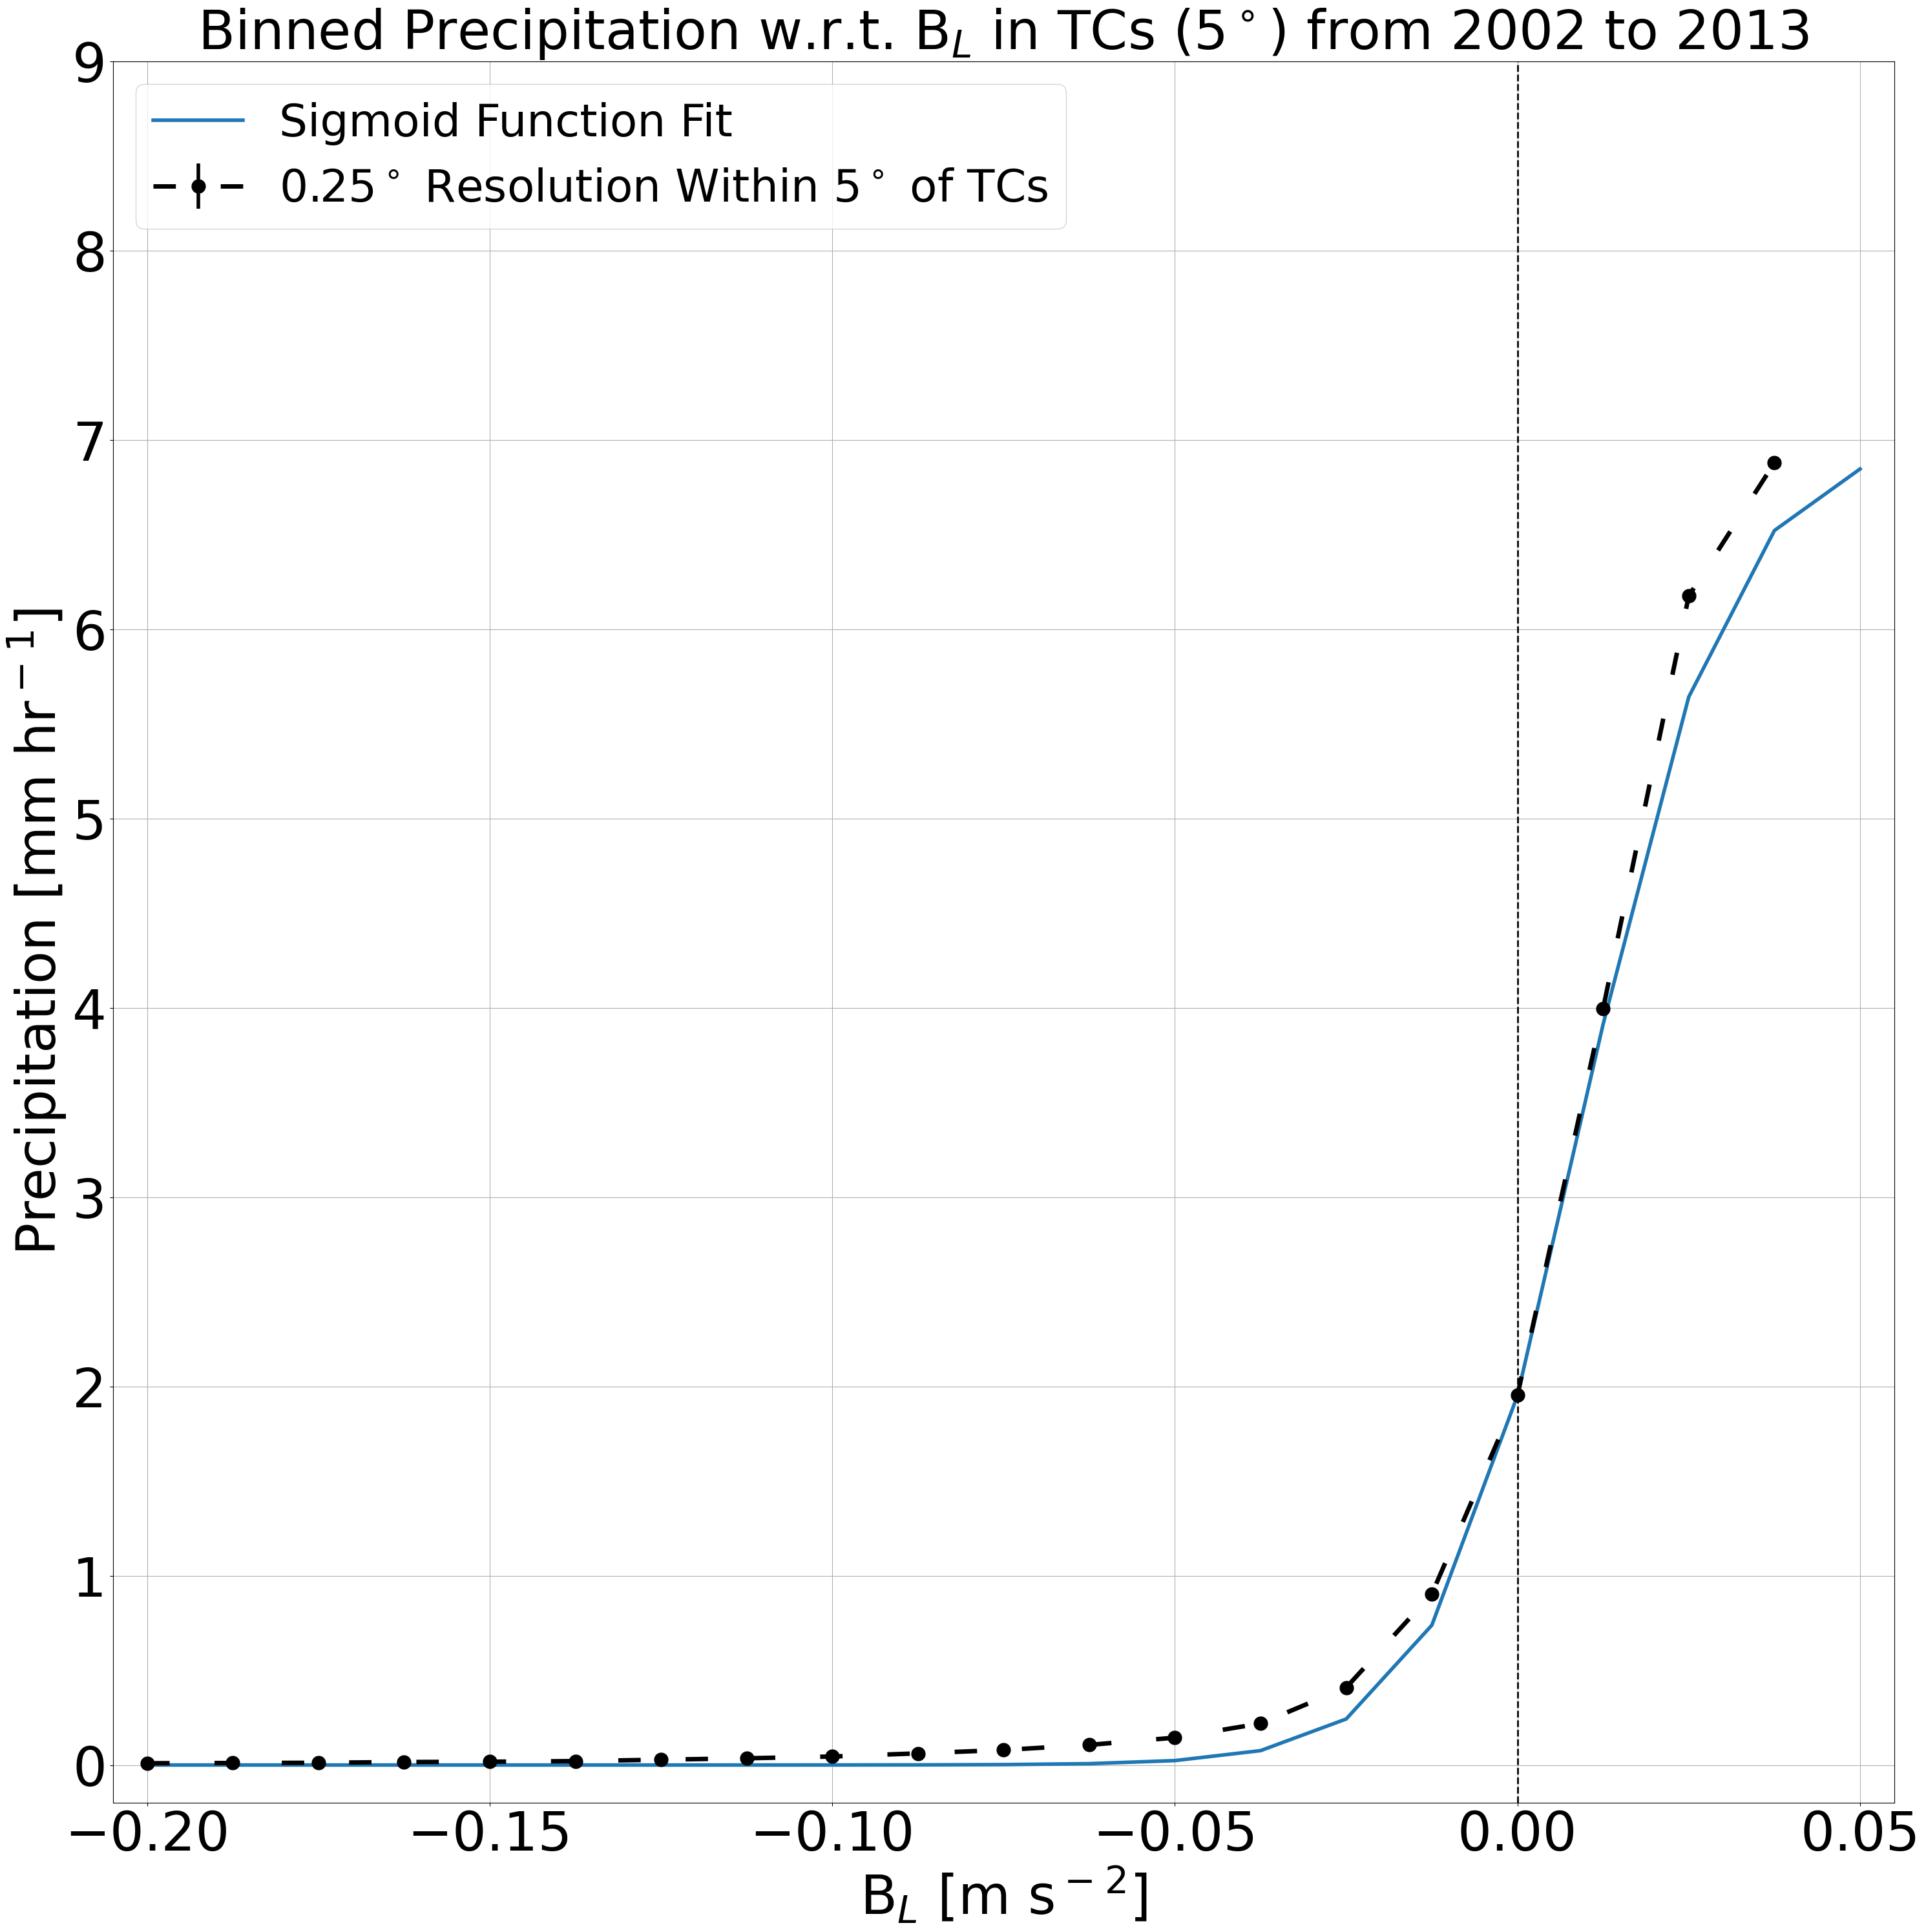

In [17]:
def sigmoid(arr, scale=1):
    '''
    Designs a sigmoid function since it seems to be the best fit to use on the precipitation pick up
    '''
    result = 7/(1 + np.exp((-arr+.01)*scale))
    return result
    
buoy_new_bins = np.asarray(buoy_new_bins) #so the bins work well in the sigmoid function
sigfit=sigmoid(buoy_new_bins,95) #trial and error to get 95 as a scale
plt.subplots(figsize = (30,30))
plt.xlabel("B$_L$ [m s$^-$$^2$]", fontsize = 60) #x and y labeling
plt.ylabel("Precipitation [mm hr$^-$$^1$]", fontsize = 60);
plt.grid()
plt.errorbar(buoy_new_bins,premean_ult,precip_err_ult,color='k',marker='o', markersize=15, linestyle=(0, (5, 10)), label = "0.25$^\circ$ Resolution Within 5$^\circ$ of TCs", elinewidth=4,linewidth=5)
#include errors to show if it is accurate or not
plt.plot(buoy_new_bins[0:21],sigfit[0:21],linewidth=4,label="Sigmoid Function Fit")
#drop the nan values

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.legend(fontsize=50,loc="upper left")
plt.locator_params(axis='y', nbins=10) 
plt.axvline(x=0,linestyle='--',color='k',linewidth=2)
plt.xlim(-.205,.055) #so there is less empty space from nan values
plt.ylim(-.2,9) #for consistency
plt.title("Binned Precipitation w.r.t. B$_L$ in TCs (5$^\circ$) from 2002 to 2013",fontsize=60)
plt.tight_layout()

In [223]:
filer=glob.glob('/MEA582/era5_2layers_thetae_2004_09_05.nc') #import a specific time step of Frances or Jeanne
#this also allows access to 3 hour intervals and slightly more accurate storm locations
big_file=xr.open_mfdataset(filer,parallel=True) #opening the data
time_string='2004-09-05T09:00:00.000000000' #take times from the NHC storm archives
time_0=big_file.sel(time=time_string) #selecting the time
CAPE_new = ((time_0.thetae_bl-time_0.thetae_sat_lt)/time_0.thetae_sat_lt)*340 #convert into CAPE
SUBSAT_new = ((time_0.thetae_sat_lt-time_0.thetae_lt)/time_0.thetae_sat_lt)*340 #convert into Subsaturation
BUOY_new = (9.8/(340*3))*((.5*CAPE_new)-(.5*SUBSAT_new)) #buoyancy
buoy=BUOY_new.compute() #computing data
buoy_levels=np.linspace(-.2,.15,15)

Text(0.5, 1.0, 'Hurricane Frances on 09/05/2004 at 09:00:00')

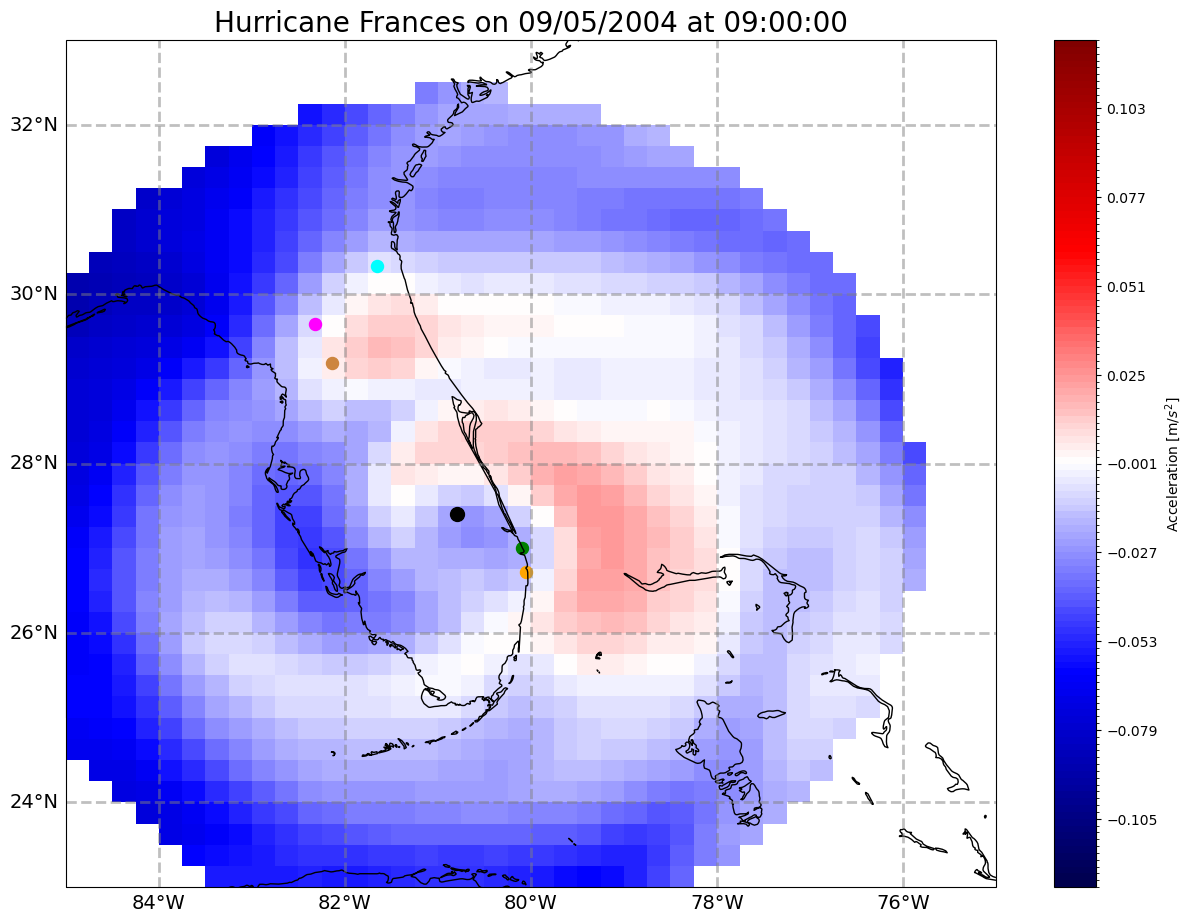

In [226]:
buoy_unit='Acceleration [m/$s^2$]' #units of buoyancy

fig,axx = plt.subplots(figsize=(15, 11),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False) #ax plot, using central longitude of 180 for a map projection
axx.coastlines() #include coastlines
#axx.set_extent(extent, crs=ccrs.PlateCarree())
axx.set_aspect('auto') 
gl = axx.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--') #create grids of 10 by 10
gl.right_labels = False #ignore labeling
gl.top_labels = False

gl.xlines = True
zz=2
levels_Buoyancy=np.arange(-.125,.125,.002) #for a consistent colormap with white as neutral buoyancy
cmap_Buoyancy=plt.get_cmap('seismic') #colormap for buoyancy
norm_Buoyancy = BoundaryNorm(levels_Buoyancy, ncolors=cmap_Buoyancy.N, clip=True) #create a smooth contour

gl.ylocator = mticker.FixedLocator(np.arange(-90,90,zz)) #set grid locations
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,zz))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


x=buoy.lon.values #take the latitude/longitude values
y=buoy.lat.values
fixx=80.8 #this is for longitude due to the nature of center location for the maps
loca=180-fixx #this is for determining the radius to look out
center_x=180+loca #take the longitude value for the storm center
center_y=27.4 #take the latitude value for the storm center
change_radii=5 #size of radius around the storm we are interested in

xx, yy = np.meshgrid(x, y)
zzz=(xx - center_x)**2 + (yy - center_y)**2 #determines circle of the meshgrid of values
wheel = (zzz <= change_radii**2) #creates a mask circle of radius change_radii across the global buoyancy values to just leave the storm values
buoy_new=buoy.where(wheel) #applies the mask to the global buoyancy

figu=axx.pcolormesh(buoy.lon,buoy.lat,buoy_new,cmap=cmap_Buoyancy,norm=norm_Buoyancy,transform=ccrs.PlateCarree())





axx.scatter((180-81.6557),30.3322,s=75,color='cyan',label="Jacksonville")
axx.scatter((180-80.0549),26.7145,s=75,color='orange',label="West Plam Beach")
axx.scatter((180-82.3250),29.6520,s=75,color='magenta',label="Gainesville")
axx.scatter((180-80.1009),27.0035,s=75,color='green',label="JD State Park")
axx.scatter((180-82.1401),29.1872,s=75,color='peru',label="Ocala")

axx.set_extent([275,285,23,33], crs=ccrs.PlateCarree())
axx.scatter(loca,center_y,s=100,color='k')
fig.colorbar(figu,label='{}'.format(buoy_unit)) #for colorbar unit
#axx.legend() for the initial plot of location names since adding a legend seems to break the plot
#change name as needed
plt.title("Hurricane Frances on {}/{}/{} at {}".format(time_string[5:7],time_string[8:10],time_string[0:4],time_string[11:19]),fontsize=20)

Jacksonville Value: 1.016290307044983
West Palm Beach Value: 0.6965073347091675
Gainesville Value: 0.9581458568572998
JD State Park Value: 0.3755475878715515
Ocala Value: 2.4593358039855957


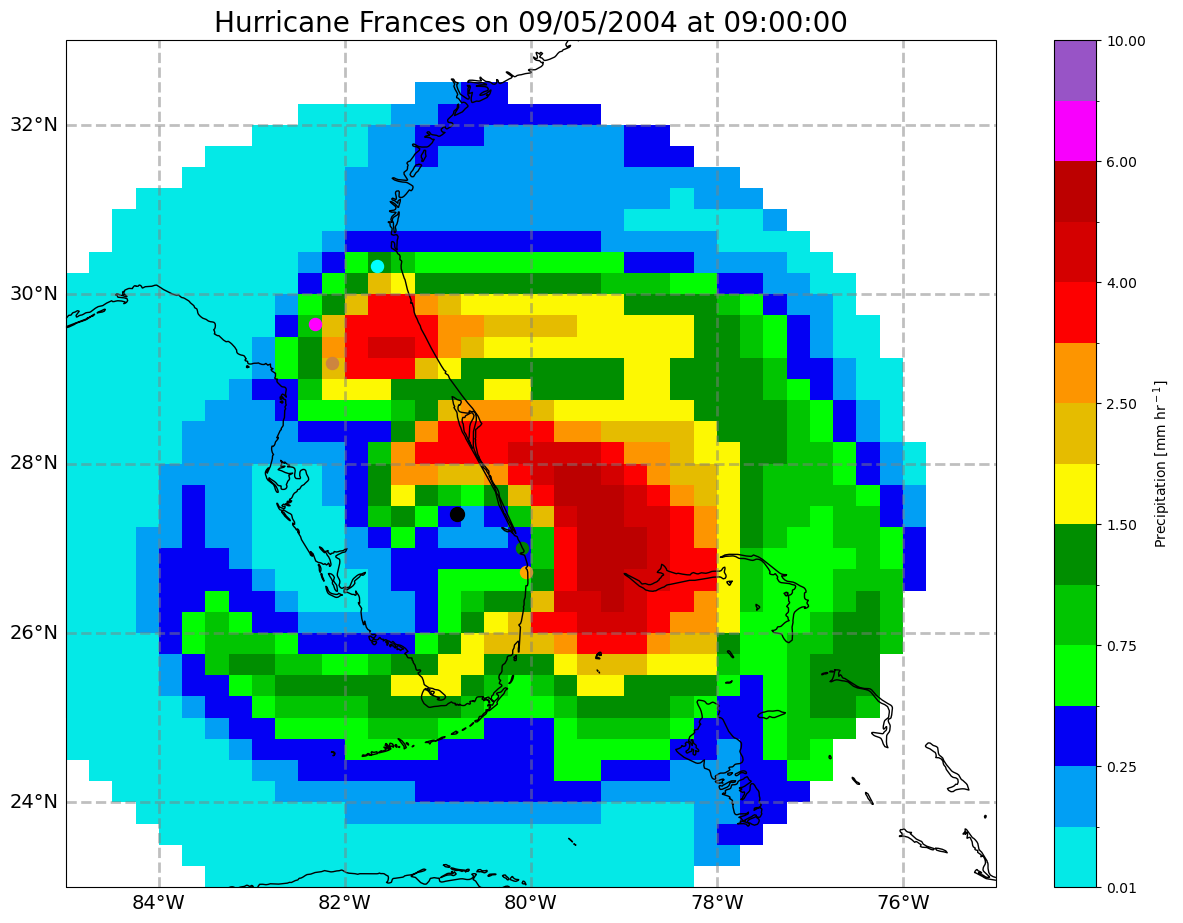

In [225]:
prec_unit= "Precipitation [mm hr$^-$$^1$]" #for precipitation
fig,axx = plt.subplots(figsize=(15, 11),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False) #ax plot, using central longitude of 180 for a map projection
axx.coastlines() #include coastlines
#axx.set_extent(extent, crs=ccrs.PlateCarree())
axx.set_aspect('auto') 
gl = axx.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--') #create grids of 10 by 10
gl.right_labels = False #ignore labeling
gl.top_labels = False

gl.xlines = True
zz=2
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,zz)) #set grid locations
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,zz))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
nws_precip_colors = [
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6",  # 8.00 - 10.00 inches
#     "#fdfdfd"   # 10.00+
] #now for precipitation, using the color values from the NWS
cmap_Precipitation= matplotlib.colors.ListedColormap(nws_precip_colors)
prec_levels=[.01,.1,.25,.5,.75,1,1.5,2,2.5,3,4,5,6,8,10]
norm_Precipitation= matplotlib.colors.BoundaryNorm(prec_levels, len(nws_precip_colors))


precip_new=sigmoid(buoy_new,95) #apply sigmoid fit to all buoyancy values
precip_new=precip_new.where(precip_new>0) #eliminate any straggler negatives just in case
figu=axx.pcolormesh(buoy.lon,buoy.lat,precip_new,cmap=cmap_Precipitation,norm=norm_Precipitation,transform=ccrs.PlateCarree())




axx.scatter((180-81.6557),30.3322,s=75,color='cyan',label="Jacksonville")
axx.scatter((180-80.0549),26.7145,s=75,color='orange',label="West Plam Beach")
axx.scatter((180-82.3250),29.6520,s=75,color='magenta',label="Gainesville")
axx.scatter((180-80.1009),27.0035,s=75,color='green',label="JD State Park")
axx.scatter((180-82.1401),29.1872,s=75,color='peru',label="Ocala")

axx.set_extent([275,285,23,33], crs=ccrs.PlateCarree())
axx.scatter(loca,center_y,s=100,color='k')
fig.colorbar(figu,label='{}'.format(prec_unit)) #for colorbar unit
#axx.legend()
plt.title("Hurricane Frances on {}/{}/{} at {}".format(time_string[5:7],time_string[8:10],time_string[0:4],time_string[11:19]),fontsize=20)
#plt.title("City Locations",fontsize=20)
jac_coord=precip_new.sel(lon=(180-81.6557)+180, lat=30.3322, method='nearest').values #to get the rainfall values for each city location
wpb_coord=precip_new.sel(lon=(180-80.0549)+180, lat=26.7145, method='nearest').values
gsv_coord=precip_new.sel(lon=(180-82.3250)+180, lat=29.6520, method='nearest').values
jdp_coord=precip_new.sel(lon=(180-80.1009)+180, lat=27.0035, method='nearest').values
oca_coord=precip_new.sel(lon=(180-82.1401)+180, lat=29.1872, method='nearest').values

#now print it for easier reading and access
print("Jacksonville Value: {}".format(jac_coord))
print("West Palm Beach Value: {}".format(wpb_coord))
print("Gainesville Value: {}".format(gsv_coord))
print("JD State Park Value: {}".format(jdp_coord))
print("Ocala Value: {}".format(oca_coord))
plt.show()

In [259]:
def interpolater(x,y):
    '''
    Performs a rough interpolation of the rainfall amounts between each 3 hour period, so it calculates the 1st hour and 2nd hour after the value
    '''
    iv = round((x+y)/2,5)
    biv = round((x+iv)/2,5)
    eiv = round((y+iv)/2,5)
    return x,biv,eiv,y
#since the precipitation values aren't all given at once, this takes it for each respective time
pre_list=[0.28517,1.08820,0.783581,.24370,1.01629]

empty_list=[]
for i in range(1,5):
    z=interpolater(pre_list[i-1],pre_list[i])
    empty_list.append(z)
empty_list=(np.reshape(empty_list, (1,16))).tolist()
unique_list_2 = []
for n in empty_list[0]:
    #this sums up all the interpolated values with the given values
    if n not in unique_list_2:
        unique_list_2.append(n)
print(round(sum(unique_list_2),5))

8.94936


## File path to processed data from David Neelin:

'/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_{}_{}*'.format(year,month)